# 2-1 프로젝트: 수염 스티커 붙이기
### 프로젝트 1. 수염 스티커 이미지
### 프로젝트 2. 마스크 이미지
##### 가상환경
- python=3.9.7
- CUDA=11.2
- CUDNN=8.1
- cmake==3.29.3
- dlib==19.24.99
- matplotlib==3.9.0

# 프로젝트 1. 수염 스티커 이미지

## 0. 라이브러리

In [18]:
import os
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
import dlib 

## 1. 이미지 확인

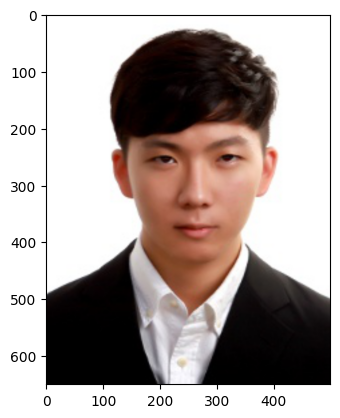

In [19]:
# 불러오기
my_image_path = 'C:/Users/lkg/Desktop/vscode/camera_sticker/images/IDPIC.png' 

img_bgr = cv2.imread(my_image_path) 
img_bgr = cv2.resize(img_bgr, (500,650)) # 이미지 크기 조절
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # 칼라 이미지
img_show = img_bgr.copy() # 이미지 복사

plt.imshow(img_rgb) 
plt.show()

## 2. 얼굴 감지
### 2.1 detector 선언
- '정면 얼굴 감지기' 반환

In [20]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()

### 2.2 얼굴 감지
- 얼굴 감지기로 탐색
- 얼굴 감지를 위한 좌표 반환

In [21]:
# 얼굴 감지 (이미지크기x1)
dlib_rects = detector_hog(img_rgb, 1)   

print(dlib_rects)

rectangles[[(142, 192) (365, 415)]]


### 2.3 얼굴 감지 확인
- 바운딩 박스의 시각화
- 얼굴 감지로 찾은 좌표 사용

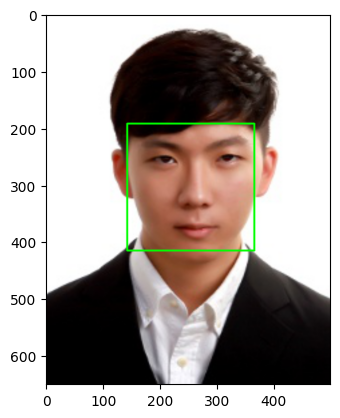

In [22]:
# 바운딩 박스
for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

# 칼라
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

## 3. 사전 훈련 모델
### Dlib-사전 훈련된 얼굴 랜드마크 감지 모델
![image](https://github.com/LeeKyoungGyu/AIFFEL-QUEST/assets/154392651/e0a0cae1-e8f2-412d-8789-e2257181ef57)

##### 68개의 랜드마크 점
- 0-16: 턱선
- 17-21: 왼쪽 눈썹
- 22-26: 오른쪽 눈썹
- 27-35: 코
- 36-41: 왼쪽 눈
- 42-47: 오른쪽 눈
- 48-60: 입 외곽
- 61-67: 입 내곽

### 3.1 모델 불러오기
- landmark_predictor: 'RGB이미지'와 'dlib.rectangle'를 입력 받고 'dlib.full_object_detection'를 반환
- dlib.rectangle: 내부를 예측하는 박스
- dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [23]:
model_path = 'C:/Users/lkg/Desktop/vscode/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

landmark_predictor = dlib.shape_predictor(model_path)

### 3.2 랜드마크 좌표
- face landmark를 찾음
- list_landmarks에 list로 저장

In [24]:
# 랜드마크의 위치를 저장할 list 생성
list_landmarks = [] 

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points) # list_landmarks에 랜드마크 리스트를 저장

print('랜드마크 개수:', len(list_landmarks[0]))
print('[60:67]의 랜드마크:', list_landmarks[0][60:])

랜드마크 개수: 68
[60:67]의 랜드마크: [(230, 376), (253, 376), (262, 378), (272, 376), (292, 375), (271, 376), (262, 379), (252, 377)]


### 3.3 랜드마크 시각화
- 이미지에 랜드마크를 표시
- cv2.circle: OpenCV의 원을 그리는 함수

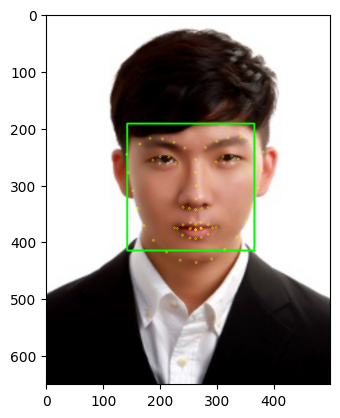

In [25]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), 1)
            

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()


## 4. 기준값 정리
- dlib_rects와 list_landmarks로 x,y,w,h 정리
- x = 윗 입술 중앙 위치
- y = 인중의 높이 좌표
- x,y = 인중 중앙 좌표
- w,h = 입술 사이의 길이

In [26]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    x = landmark[51][0] # 윗 입술 중앙
    y = landmark[33][1]+(landmark[51][1] - landmark[33][1])//2 # 콧볼 + 입술사이거리/2((코끝-입술끝)/2)
    w = h = landmark[54][0]-landmark[48][0]
    
    print ('인중좌표' f'(x,y) : ({x},{y})')
    print ('입술가로길이' f'(w,h) : ({w},{h})')

인중좌표(x,y) : (262,356)
입술가로길이(w,h) : (73,73)


## 5. 스티커 이미지
### 5.1 스티커 이미지 불러오기
- 수염 이미지 불러오기
- 이미지의 사이즈는 입술길이로 재 설정
  - (w,h) = (73,73)

(73, 73, 3)


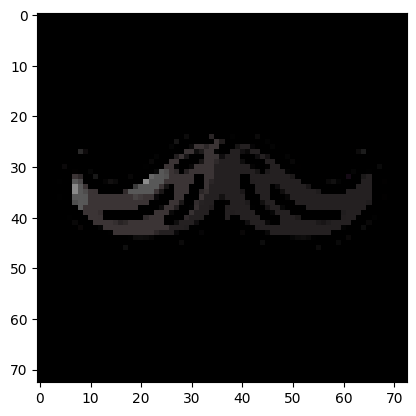

In [27]:
sticker_path = 'C:/Users/lkg/Desktop/vscode/camera_sticker/images/beard.png' # 수염의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지 불러오기
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 : 입술 길이
print (img_sticker.shape) # 이미지 크기와 차원 확인

#img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB) 
plt.imshow(img_sticker)
plt.show()

### 5.2 스티커 이미지 시작 지점
- 수염이미지가 시작되는 좌표 설정
- refined_x : 인중의x좌표 - 입술길이/2
- refined_y : 인중의y좌표 - 입술길이/2

In [28]:
# 시작점 정의
refined_x = x - w // 2 # 인중의x좌표 - 입술길이/2
refined_y = y - h // 2 # 인중의y좌표 - 입술길이/2

# 좌표
print ('수염이미지의 시작 좌표'f'(x,y) : ({refined_x},{refined_y})')

수염이미지의 시작 좌표(x,y) : (226,320)


- 시작점의 음수처리

In [29]:
# 음수 처리
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] 
    refined_y = 0

print ('수염이미지의 시작 좌표'f'(x,y) : ({refined_x},{refined_y})')

수염이미지의 시작 좌표(x,y) : (226,320)


## 6. 스티커 이미지 적용
### 6.1 스티커 이미지 테스트
- sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
- 앞서 적용한 바운딩박스, 랜드마크의 이미지에 적용
- np.where: 스티커이미지에서 값이 0인(투명한) 부분-원본이미지 / 투명하지 않은 부분-스티커이미지
- img_sticker.shape = (세로,가로,채널)

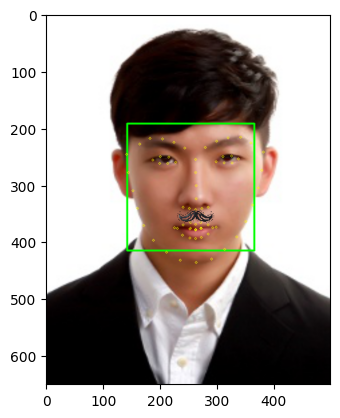

In [30]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 6.2 결과 : 스티커 이미지 합성

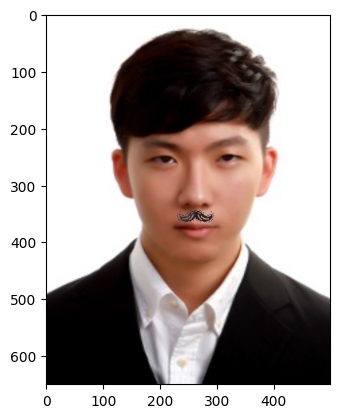

In [31]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 프로젝트 2. 마스크 스티커 이미지

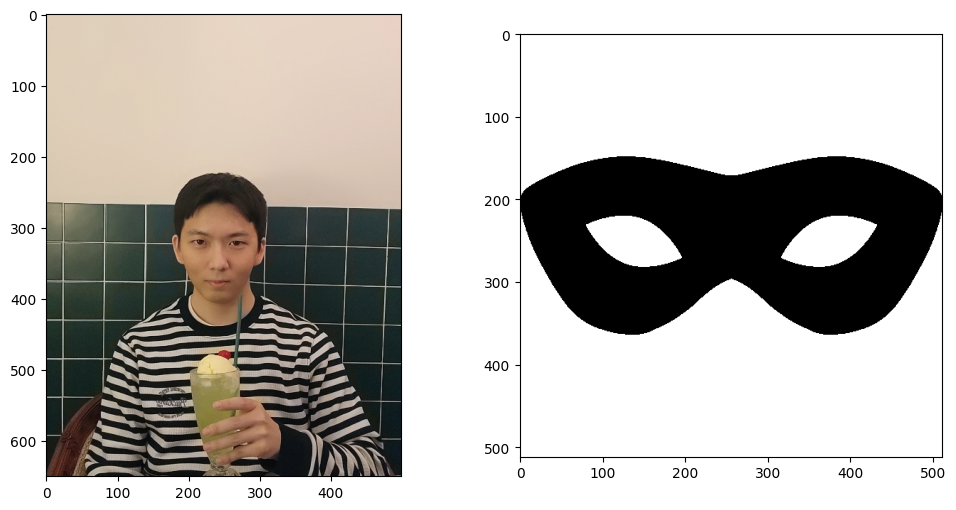

In [32]:
my_image_path = 'C:/Users/lkg/Desktop/vscode/camera_sticker/images/selfpic.png' 

img_bgr = cv2.imread(my_image_path) 
img_bgr = cv2.resize(img_bgr, (500,650)) # 이미지 크기 조절
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # 칼라 이미지
img_show = img_bgr.copy() # 이미지 복사

sticker_path = 'C:/Users/lkg/Desktop/vscode/camera_sticker/images/mask.png' # 마스크의 경로
img_sticker = cv2.imread(sticker_path)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_rgb)
axes[1].imshow(img_sticker)
plt.show()

In [33]:
# 얼굴감지
dlib_rects = detector_hog(img_rgb, 1) # rectangles[[(187, 295) (294, 402)]] 

# 랜드마크
list_landmarks = [] 
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) 
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) 
    list_landmarks.append(list_points) 

# 기준 설정 (미간)
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[27][0] # 미간 중앙
    y = landmark[27][1] # 미간 중앙
    w = h = dlib_rect.width() # 얼굴 픽셀 크기
    
print ('미간좌표' f'(x,y) : ({x},{y})')
print ('얼굴픽셀크기' f'(w,h) : ({w},{h})')
# 미간좌표(x,y) : (242,321)
# 얼굴픽셀크기(w,h) : (108,108)

# 스티커 이미지 편집
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 : 얼굴픽셀크기
# img_sticker = cv2.bitwise_not(img_sticker) # 이미지 알파 반전

# 시작점 정의
refined_x = x - w // 2 # 미간의x좌표 - 스티커길이/2
refined_y = y - h // 2 # 미간의y좌표 - 스티커길이/2

# 좌표
print ('마스크이미지의 시작 좌표'f'(x,y) : ({refined_x},{refined_y})')
# 마스크이미지의 시작 좌표(x,y) : (188,267)



미간좌표(x,y) : (242,321)
얼굴픽셀크기(w,h) : (108,108)
마스크이미지의 시작 좌표(x,y) : (188,267)


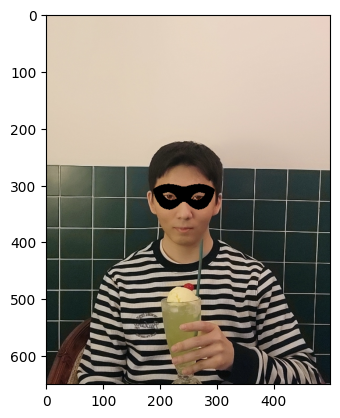

In [34]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 회고
배운점 : Dlib라이브러리로 얼굴을 인지하고 감지하는 모델에 대해 알 수 있었다

느낀점 : 잘 훈련된 사전 모델을 불러와 진행하니 빠른 적용이 가능했다

아쉬운 점 : 프로젝트 1에서 생각했던 것 만큼 수염이 그려지지 않았다. 
픽셀값을==0이외 더 추가해야 할 것 같다.
수염의 크기가 작다.

어려웠던 점 : 마지막 스티커 이미지를 적용할 때, 색 반전이 있었다.
img_sticker = cv2.bitwise_not(img_sticker) 등의 방법을 추가할 수 있을 것 같다 